# Noisy Likelihoods

## Setup

First, let's set up some environmental dependencies. These just make the numerics easier and adjust some of the plotting defaults to make things more legible.

In [1]:
# system functions that are always useful to have
import time, sys, os

# basic numeric setup
import numpy as np
from numpy import linalg

# inline plotting
%matplotlib inline

# plotting
import matplotlib
from matplotlib import pyplot as plt

# seed the random number generator
rstate = np.random.default_rng(819)

In [2]:
# re-defining plotting defaults
from matplotlib import rcParams
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'font.size': 30})

In [3]:
import dynesty

# Noisy Likelihoods

In some problems, we don't actually have access to the likelihood $\mathcal{L}(\mathbf{x})$ because it might be intractable or numerically infeasible to compute. Instead, we are able to compute a noisy estimate

$$ \mathcal{L}^\prime(\mathbf{x}) \sim P(\mathcal{L} | \mathbf{x}, \boldsymbol{\theta}) $$

as a function of the "true" likelihood $\mathcal{L}$ that depends on some hyper-parameters $\boldsymbol{\theta}$ (e.g., the number of Monte Carlo draws used in the approximation) and might also vary as a function of position $\mathbf{x}$.

There are several methods for dealing with noisy (i.e. stochastic) likelihoods in an MCMC context (see, e.g., pseudo-marginal MCMC), but at first glance this might seem difficult to deal with in Nested Sampling since we require the likelihood for each sample to be monotonically increasing. This will inevitably lead to biased inference, since positive fluctuations can skew later results to also be positive. We can, however, still recover the true distribution by making judicious use of **importance reweighting** to re-assign a new set of likelihood realizations to our results.

# 3-D Multivariate Normal

To demonstrate this, we will again utilize a 3-D **multivariate Normal** distribution.

In [4]:
ndim = 3  # number of dimensions
C = np.identity(ndim)  # set covariance to identity matrix
Cinv = linalg.inv(C)  # precision matrix
lnorm = -0.5 * (np.log(2 * np.pi) * ndim + np.log(linalg.det(C)))  # ln(normalization)

# 3-D correlated multivariate normal log-likelihood
def loglikelihood(x):
    """Multivariate normal log-likelihood."""
    return -0.5 * np.dot(x, np.dot(Cinv, x)) + lnorm

We'll again define our prior (via `prior_transform`) to be uniform in each dimension from -10 to 10 and 0 everywhere else.

In [5]:
# prior transform
def prior_transform(u):
    """Transforms our unit cube samples `u` to a flat prior between -10. and 10. in each variable."""
    return 10. * (2. * u - 1.)

## Noiseless Case

Let's first generate samples from this noiseless target distribution.

In [6]:
# initialize our nested sampler
dsampler = dynesty.DynamicNestedSampler(loglikelihood, prior_transform, ndim=3,
                                        bound='single', sample='unif', rstate=rstate)
dsampler.run_nested(maxiter=20000, use_stop=False)
dres = dsampler.results

20001it [00:13, 1527.19it/s, batch: 10 | bound: 0 | nc: 1 | ncall: 53238 | eff(%): 37.569 | loglstar:   -inf < -2.836 < -3.034 | logz: -8.902 +/-  0.052 | stop:    nan]          


## Noisy Case

Now let's generate samples from a noisy version. Here we'll assume that we have a noisy estimate of our "model", which here is $f(\mathbf{x}) = \mathbf{x}$ such that

$$ \mathbf{x}^\prime \sim \mathcal{N}(\mathbf{x}, \sigma=1.) $$

Since our "true" model is $\mathbf{x} = 0$ and our prior ranges from $-10$ to $10$, this is roughly equivalent to assuming $\sim 10\%$ uncertainty in each dimension.

In [7]:
noise = 1.

# 3-D correlated multivariate normal log-likelihood
def loglikelihood2(x):
    """Multivariate normal log-likelihood."""
    xp = rstate.normal(x, noise)
    logl = -0.5 * np.dot(xp, np.dot(Cinv, xp)) + lnorm
    scale = - 0.5 * noise**2  # location and scale
    bias_corr = scale * ndim  # ***bias correction term***
    return logl - bias_corr

Note the additional **bias correction** term we have now included in the log-likelihood. This ensures that our noisy likelihood is unbiased relative to the true likelihood.

In [8]:
# compute estimator
x = np.zeros(ndim)
logls = np.array([loglikelihood2(x) for i in range(10000)])

print('True log-likelihood:', loglikelihood(x))
print('Estimated:', np.mean(logls), '+/-', np.std(logls))

True log-likelihood: -2.756815599614018
Estimated: -2.7557381720711165 +/- 1.2451802664203007


Let's now sample from our noisy distribution.

In [9]:
dsampler2 = dynesty.DynamicNestedSampler(loglikelihood2, prior_transform, ndim=3,
                                         bound='single', sample='unif', 
                                         update_interval=50., 
                                        rstate=rstate)
dsampler2.run_nested(maxiter=20000, use_stop=False)
dres2 = dsampler2.results

20001it [03:50, 86.59it/s, batch: 10 | bound: 0 | nc: 1 | ncall: 1452390 | eff(%):  1.377 | loglstar:   -inf < -1.305 < -1.583 | logz: -7.547 +/-  0.053 | stop:    nan]            


As expected, sampling is substantially more inefficient in the noisy case since more likelihood calls are required to get a noisy realization that is "better" than the previous noisy realization.

## Comparing Results

Comparing the two results, we see that the noise in our model appears to give a larger estimate for the evidence. This is what we'd expect given that our sampling will preferentially be biased to noisy realizations with larger-than-expected log-likelihoods at any given position.

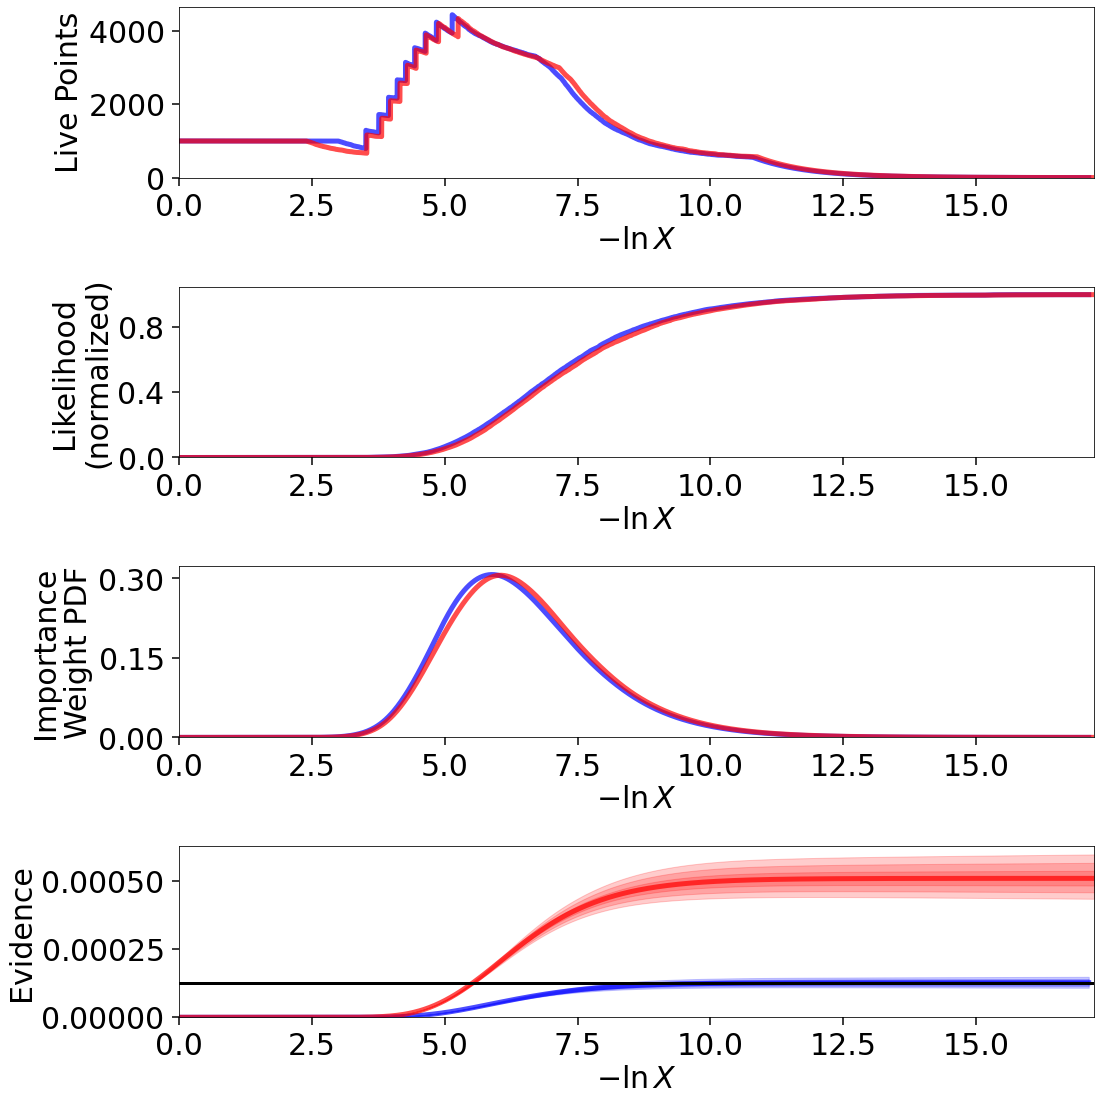

In [10]:
# plot results
from dynesty import plotting as dyplot

lnz_truth = ndim * -np.log(2 * 10.)  # analytic evidence solution
fig, axes = dyplot.runplot(dres, color='blue')  # noiseless
fig, axes = dyplot.runplot(dres2, color='red',  # noisy
                           lnz_truth=lnz_truth, truth_color='black',
                           fig=(fig, axes))
fig.tight_layout()

This effect also propagates through to our posteriors, broadening them relative to the underlying distribution.

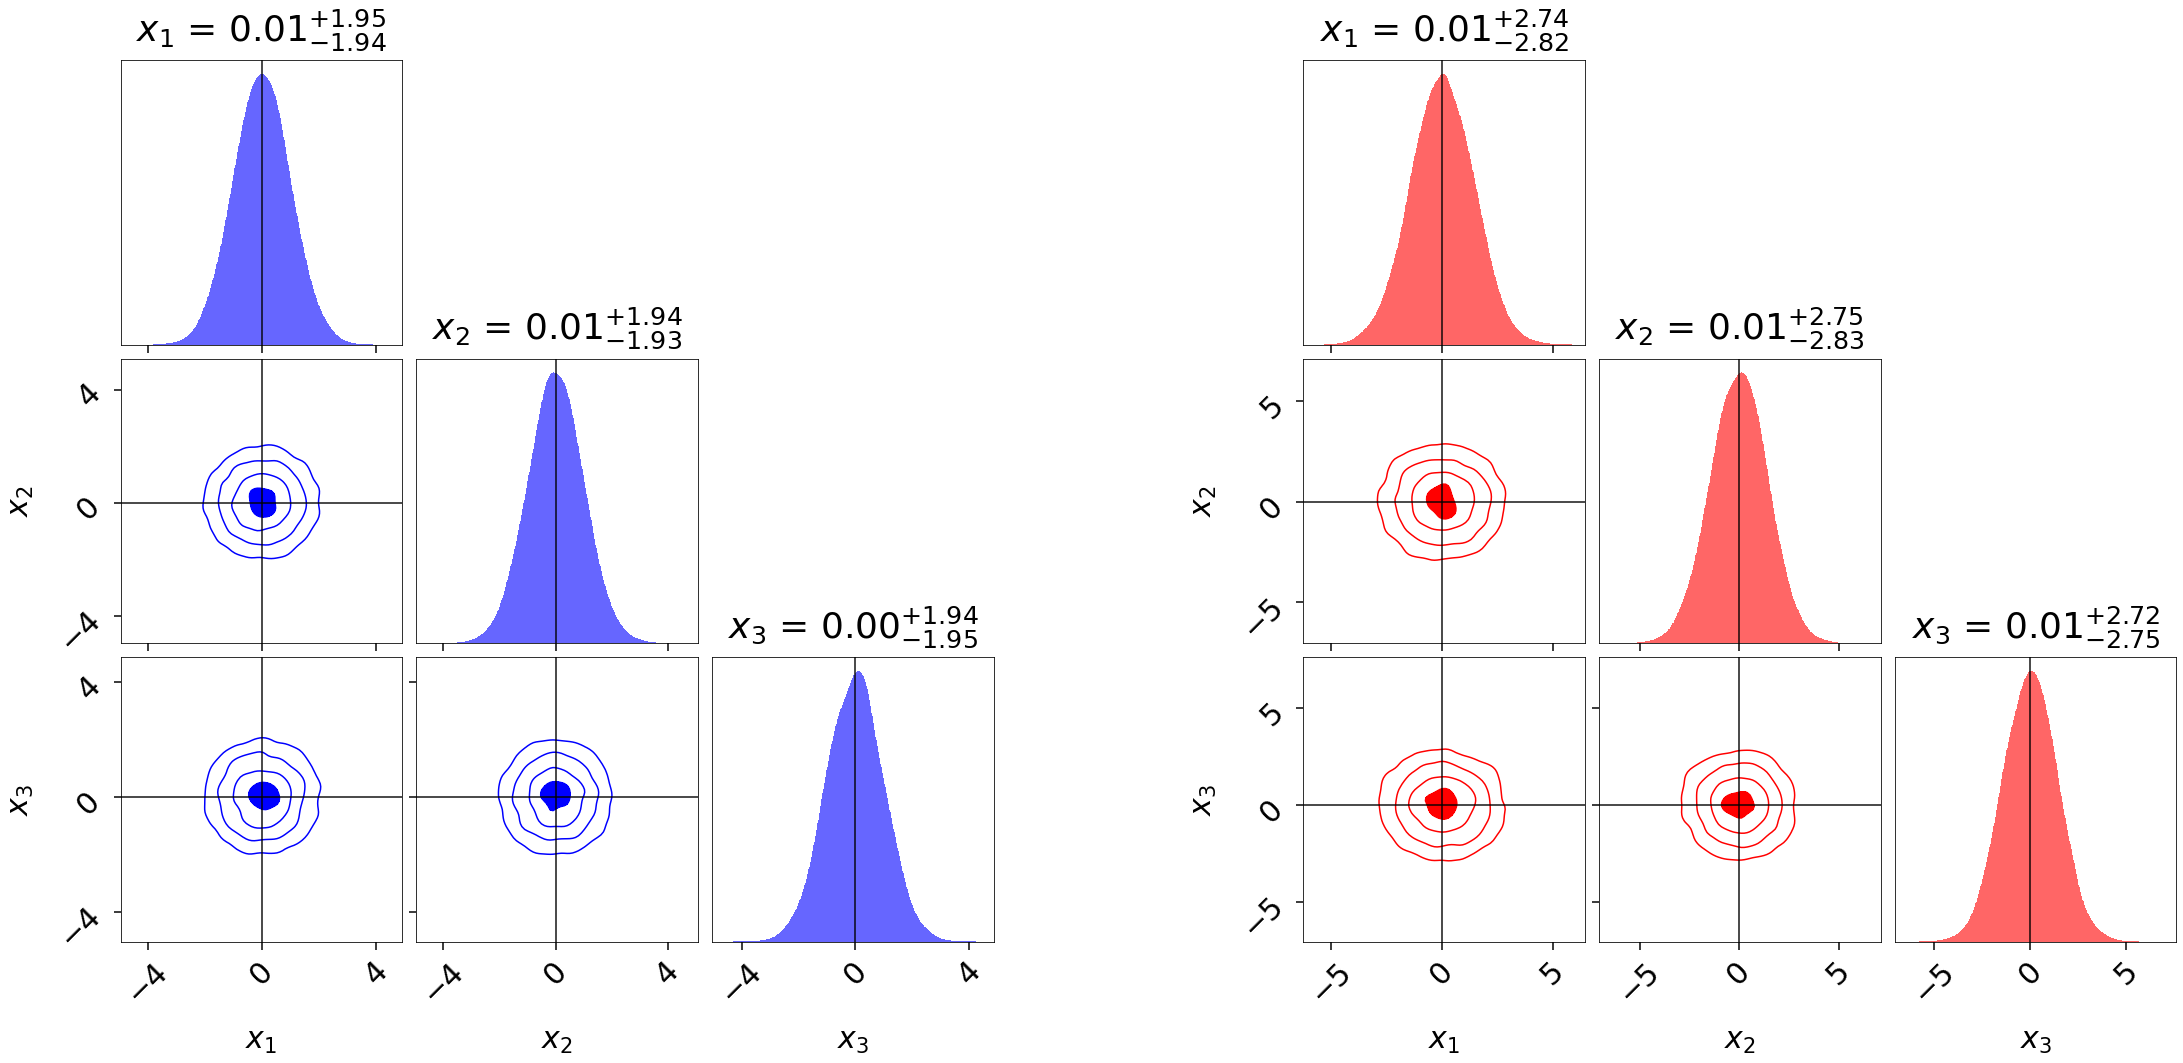

In [11]:
# initialize figure
fig, axes = plt.subplots(3, 7, figsize=(35, 15))
axes = axes.reshape((3, 7))
[a.set_frame_on(False) for a in axes[:, 3]]
[a.set_xticks([]) for a in axes[:, 3]]
[a.set_yticks([]) for a in axes[:, 3]]

# plot noiseless run (left)
fg, ax = dyplot.cornerplot(dres, color='blue', truths=[0., 0., 0.], truth_color='black',
                           show_titles=True, max_n_ticks=3, title_kwargs={'y': 1.05},
                           quantiles=None, fig=(fig, axes[:, :3]))

# plot noisy run (right)
fg, ax = dyplot.cornerplot(dres2, color='red', truths=[0., 0., 0.], truth_color='black',
                           show_titles=True, title_kwargs={'y': 1.05},
                           quantiles=None, max_n_ticks=3, fig=(fig, axes[:, 4:]))

## Importance Reweighting

If we knew the "true" likelihood, we could naively use importance reweighting to reweight our noiseless samples to approximate the "correct" distribution, as shown below.

In [12]:
# importance reweighting
logl = np.array([loglikelihood(s) for s in dres2.samples])
dres2_rwt = dynesty.utils.reweight_run(dres2, logl)

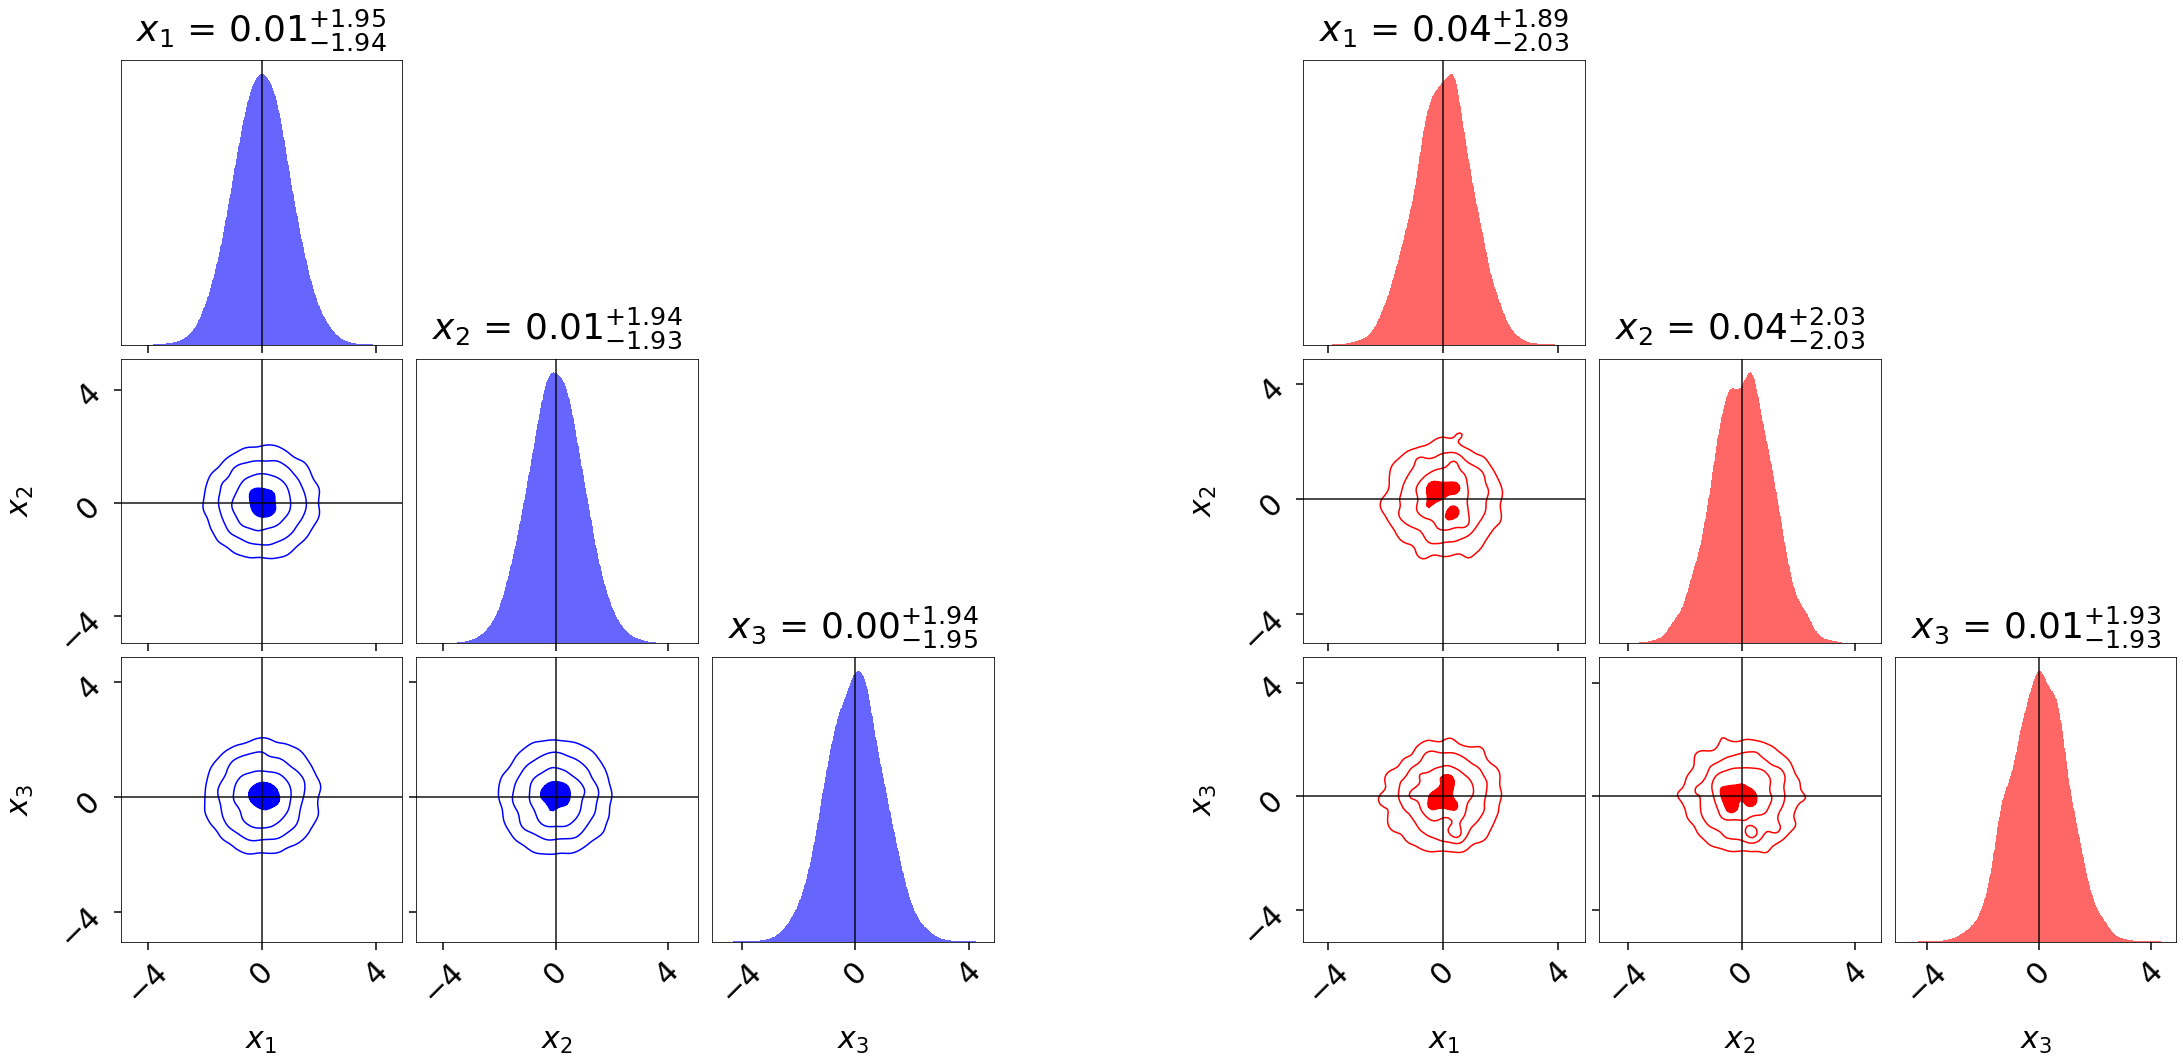

In [13]:
# initialize figure
fig, axes = plt.subplots(3, 7, figsize=(35, 15))
axes = axes.reshape((3, 7))
[a.set_frame_on(False) for a in axes[:, 3]]
[a.set_xticks([]) for a in axes[:, 3]]
[a.set_yticks([]) for a in axes[:, 3]]

# plot noiseless run (left)
fg, ax = dyplot.cornerplot(dres, color='blue', truths=[0., 0., 0.], truth_color='black',
                           show_titles=True, max_n_ticks=3, title_kwargs={'y': 1.05},
                           quantiles=None, fig=(fig, axes[:, :3]))

# plot reweighted noisy run (right)
fg, ax = dyplot.cornerplot(dres2_rwt, color='red', truths=[0., 0., 0.], truth_color='black',
                           show_titles=True, title_kwargs={'y': 1.05},
                           quantiles=None, max_n_ticks=3, fig=(fig, axes[:, 4:]))

## Full Analysis

In general, however, we don't have access to the true likelihood. In that case, we need to incorporate importance reweighting into our error analysis. One possible approach would be the naive scheme outlined below, where we just add in an importance reweighting step as part of the error budget. Note that it's important that this reweighting step happens at the end since `simulate_run` (re-)sorts the samples.

In [15]:
Nmc = 50

# compute realizations of covariances (noiseless)
covs = []
for i in range(Nmc):
    if i % 5 == 0: sys.stderr.write(str(i)+' ')
    dres_t = dynesty.utils.resample_run(dres)
    x, w = dres_t.samples, np.exp(dres_t.logwt - dres_t.logz[-1])
    covs.append(dynesty.utils.mean_and_cov(x, w)[1].flatten())

# noisy case (ignoring reweighting)
covs2 = []
for i in range(Nmc):
    if i % 5 == 0: sys.stderr.write(str(i)+' ')
    dres2_t = dynesty.utils.resample_run(dres2)
    x, w = dres2_t.samples, np.exp(dres2_t.logwt - dres2_t.logz[-1])
    covs2.append(dynesty.utils.mean_and_cov(x, w)[1].flatten())
    
# noisy case (w/ naive reweighting)
covs3 = []
for i in range(Nmc):
    if i % 5 == 0: sys.stderr.write(str(i)+' ')
    dres2_t = dynesty.utils.resample_run(dres2)
    logl_t = np.array([loglikelihood2(s) for s in dres2_t.samples])
    dres2_t = dynesty.utils.reweight_run(dres2_t, logp_new=logl_t)
    x, w = dres2_t.samples, np.exp(dres2_t.logwt - dres2_t.logz[-1])
    covs3.append(dynesty.utils.mean_and_cov(x, w)[1].flatten())

0 5 10 15 20 25 30 35 40 45 0 5 10 15 20 25 30 35 40 45 0 5 10 15 20 25 30 35 40 45 

In [16]:
# compute errors
cov_mean, cov_std = np.mean(covs, axis=0), np.std(covs, axis=0)
cov2_mean, cov2_std = np.mean(covs2, axis=0), np.std(covs2, axis=0)
cov3_mean, cov3_std = np.mean(covs3, axis=0), np.std(covs3, axis=0)

# print results
print('Noiseless Likelihood Std:\n', cov_mean[[0, 4, 8]], 
      '+/-', cov_std[[0, 4, 8]])
print('Noisy Likelihood Std:\n', cov2_mean[[0, 4, 8]], 
      '+/-', cov2_std[[0, 4, 8]])
print('Noisy Likelihood (Naive Reweight) Std:\n', cov3_mean[[0, 4, 8]], 
      '+/-', cov3_std[[0, 4, 8]])

Noiseless Likelihood Std:
 [0.98761864 0.97586124 0.99700526] +/- [0.01228148 0.01192553 0.01076748]
Noisy Likelihood Std:
 [2.01503658 2.01814817 1.98035144] +/- [0.02217458 0.02164256 0.02088175]
Noisy Likelihood (Naive Reweight) Std:
 [1.97454929 2.15254034 1.95635744] +/- [0.19677285 0.16332414 0.15124063]


While including the noise from our intrinsic likelihoods appears to substantially increase our error budget, it didn't actually shift our mean prediction closer to the truth. What gives? The issue is that we aren't accounting for the fact that we are able to get an estimate of the true (expected) log-likelihood from our many repeated realizations (via the mean). We can estimate this and our possible uncertainties around the mean using bootstrapping.

In [17]:
# compute sample mean and std(sample mean)
logls = np.array([[loglikelihood2(s) for s in dres2.samples] for i in range(Nmc)])
logls_est = logls.mean(axis=0)  # sample mean
logls_bt = []
for i in range(Nmc * 10):
    idx = rstate.choice(Nmc, size=Nmc)
    logls_bt.append(logls[idx].mean(axis=0))  # bootstrapped mean
logls_std = np.std(logls_bt, axis=0)  # bootstrapped std(mean)

In [19]:
# noisy case (w/ mean reweighting)
covs4 = []
for i in range(Nmc):
    if i % 5 == 0: sys.stderr.write(str(i)+' ')
    dres2_t, idx = dynesty.utils.resample_run(dres2, return_idx=True)
    logl_t = rstate.normal(logls_est[idx], logls_std[idx])
    dres2_t = dynesty.utils.reweight_run(dres2_t, logp_new=logl_t)
    x, w = dres2_t.samples, np.exp(dres2_t.logwt - dres2_t.logz[-1])
    covs4.append(dynesty.utils.mean_and_cov(x, w)[1].flatten())

0 5 10 15 20 25 30 35 40 45 

In [20]:
# print results
cov4_mean, cov4_std = np.mean(covs4, axis=0), np.std(covs4, axis=0)
print('Noiseless Likelihood Std:\n', cov_mean[[0, 4, 8]], 
      '+/-', cov_std[[0, 4, 8]])
print('Noisy Likelihood Std:\n', cov2_mean[[0, 4, 8]], 
      '+/-', cov2_std[[0, 4, 8]])
print('Noisy Likelihood (Naive Reweight) Std:\n', cov3_mean[[0, 4, 8]], 
      '+/-', cov3_std[[0, 4, 8]])
print('Noisy Likelihood (Mean+Bootstrap Reweight) Std:\n', cov4_mean[[0, 4, 8]], 
      '+/-', cov4_std[[0, 4, 8]])

Noiseless Likelihood Std:
 [0.98761864 0.97586124 0.99700526] +/- [0.01228148 0.01192553 0.01076748]
Noisy Likelihood Std:
 [2.01503658 2.01814817 1.98035144] +/- [0.02217458 0.02164256 0.02088175]
Noisy Likelihood (Naive Reweight) Std:
 [1.97454929 2.15254034 1.95635744] +/- [0.19677285 0.16332414 0.15124063]
Noisy Likelihood (Mean+Bootstrap Reweight) Std:
 [1.04497056 1.10240283 1.03198737] +/- [0.02183097 0.02868237 0.02407005]


We see that after reweighting using our mean likelihoods (with bootstrapped errors) now properly shifts the mean while leaving us with uncertainties that are slightly larger than the noiseless case. This is what we'd expect given that we only have a noisy estimate of the true log-likelihood at a given position.

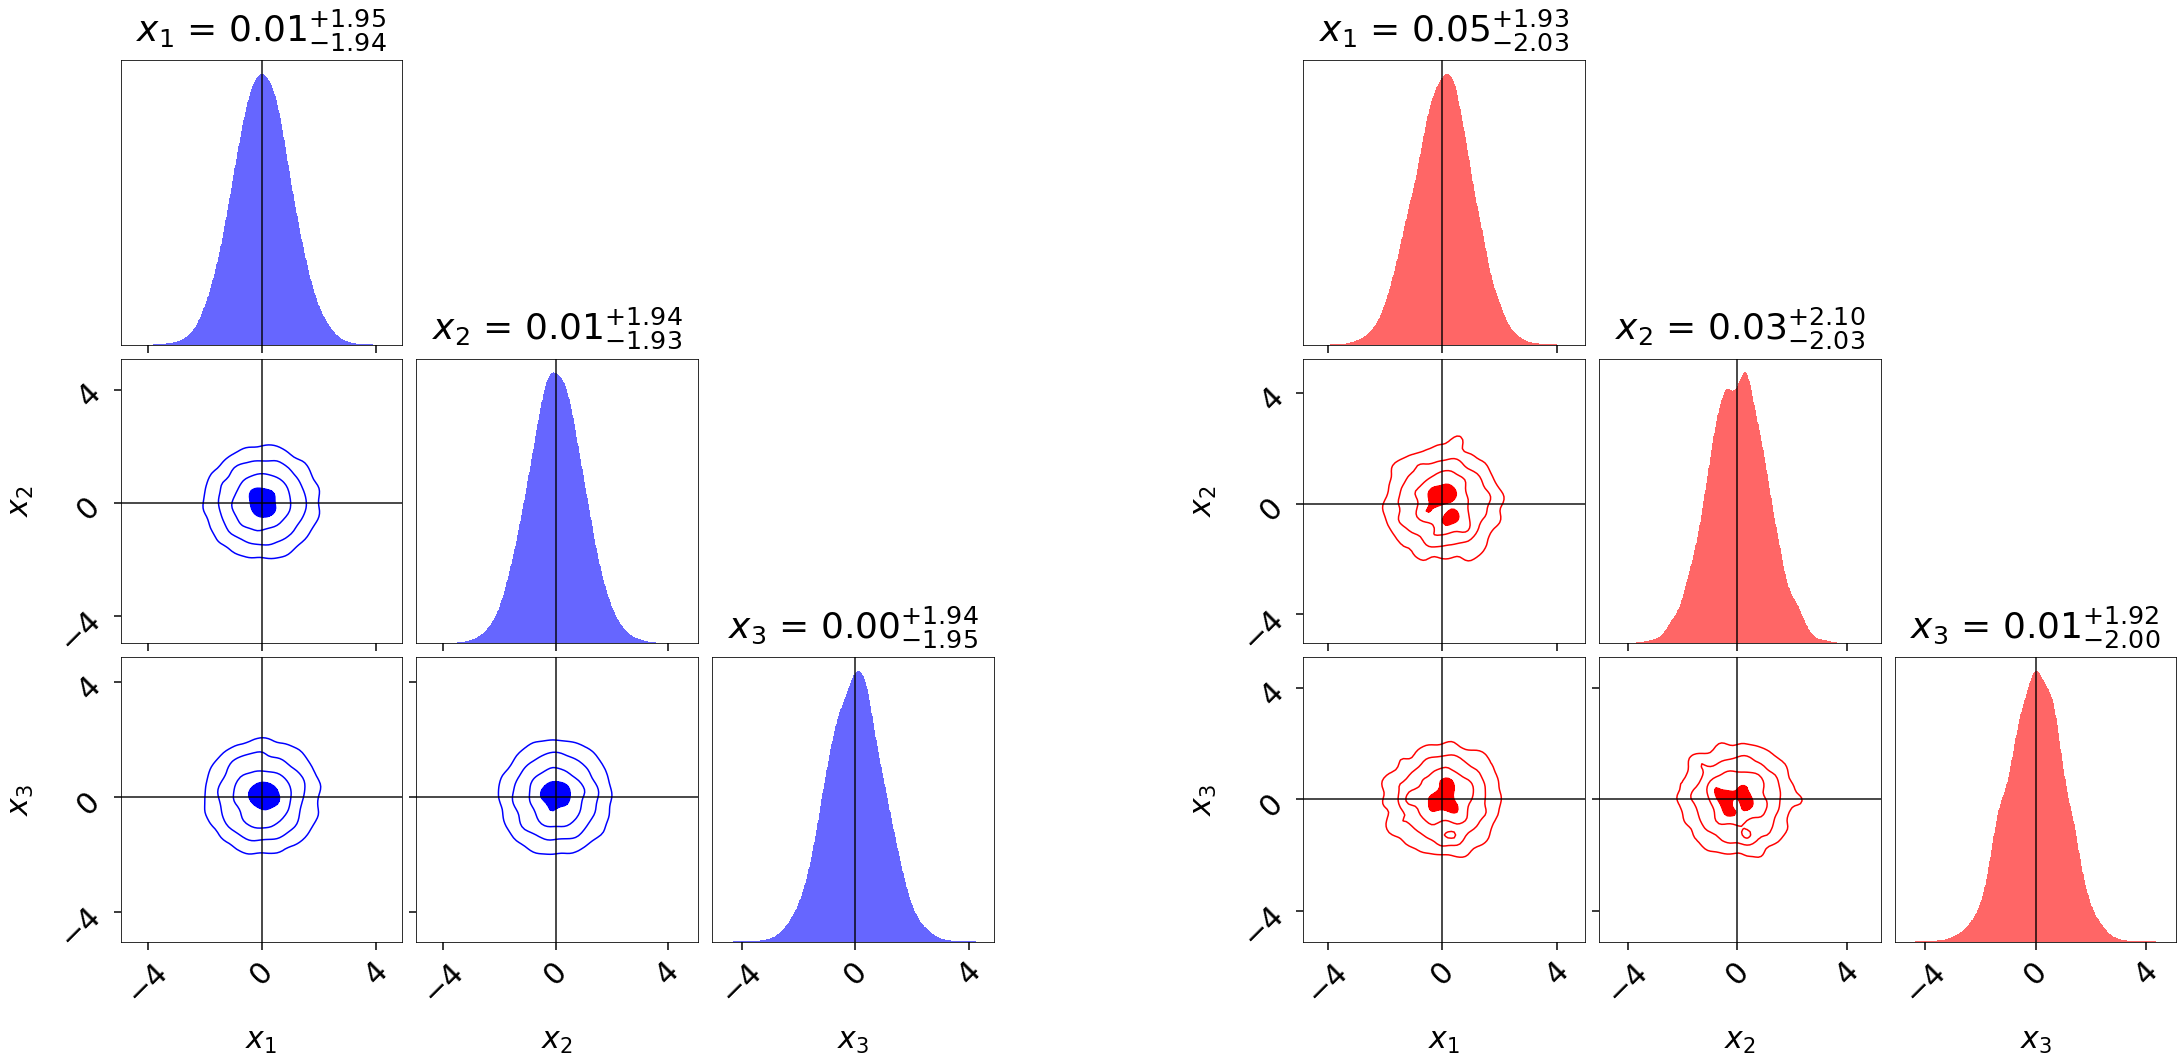

In [21]:
# initialize figure
fig, axes = plt.subplots(3, 7, figsize=(35, 15))
axes = axes.reshape((3, 7))
[a.set_frame_on(False) for a in axes[:, 3]]
[a.set_xticks([]) for a in axes[:, 3]]
[a.set_yticks([]) for a in axes[:, 3]]

# plot noiseless run (left)
fg, ax = dyplot.cornerplot(dres, color='blue', truths=[0., 0., 0.], truth_color='black',
                           show_titles=True, max_n_ticks=3, title_kwargs={'y': 1.05},
                           quantiles=None, fig=(fig, axes[:, :3]))

# plot realization of reweighted run (right)
logl_t = rstate.normal(logls_est, logls_std)
dres2_rwt2 = dynesty.utils.reweight_run(dres2, logp_new=logl_t)
fg, ax = dyplot.cornerplot(dres2_rwt2, color='red', truths=[0., 0., 0.], truth_color='black',
                           show_titles=True, title_kwargs={'y': 1.05},
                           quantiles=None, max_n_ticks=3, fig=(fig, axes[:, 4:]))